<a href="https://colab.research.google.com/github/Srikar1718/Super-Resolution-of-Pixelated-Images-with-SRGAN-and-EDSR/blob/main/EDSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib scikit-image --quiet


In [ ]:
import os
import requests
import zipfile

div2k_url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
save_path = "DIV2K_train_HR.zip"

if not os.path.exists("DIV2K_train_HR"):
    print("Downloading DIV2K HR images...")
    r = requests.get(div2k_url, stream=True)
    with open(save_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Extracting...")
    with zipfile.ZipFile(save_path, 'r') as zip_ref:
        zip_ref.extractall(".")
else:
    print("DIV2K HR images already available.")


Extracting...


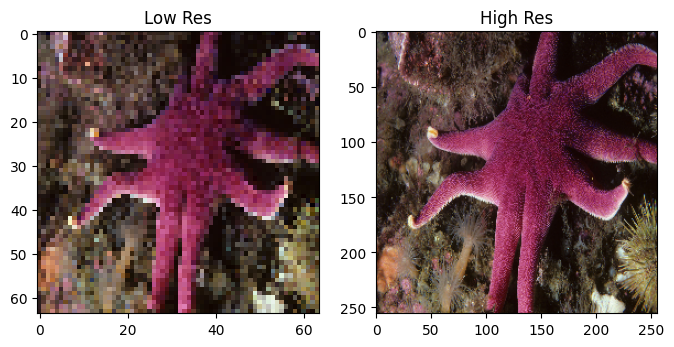

In [ ]:
import cv2
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

def preprocess(image_path, scale=4):
    hr = cv2.imread(image_path)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    hr = cv2.resize(hr, (256, 256))
    lr = cv2.resize(hr, (64, 64), interpolation=cv2.INTER_CUBIC)
    return lr / 255., hr / 255.

lr, hr = preprocess("DIV2K_train_HR/0001.png")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(lr); plt.title("Low Res")
plt.subplot(1,2,2); plt.imshow(hr); plt.title("High Res")
plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Add
from tensorflow.keras.models import Model

def edsr(scale=4, num_filters=64, num_res_blocks=8):
    def res_block(x):
        skip = x
        x = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
        x = Conv2D(num_filters, 3, padding='same')(x)
        return Add()([skip, x])

    inp = Input(shape=(None, None, 3))
    x = Conv2D(num_filters, 3, padding='same')(inp)
    skip = x

    for _ in range(num_res_blocks):
        x = res_block(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Add()([x, skip])
    x = Conv2D(3, 3, padding='same')(x)
    return Model(inp, x)

edsr_model = edsr()
edsr_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      1,792 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │     36,928 │ conv2d[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_1[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ conv2d[0][0],     │
│                     │ None, 64)         │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │     36,928 │ add[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_3[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ add[0][0],        │
│                     │ None, 64)         │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │     36,928 │ add_1[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_5[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None,      │          0 │ add_1[0][0],      │
│                     │ None, 64)         │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │     36,928 │ add_2[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_7[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None,      │          0 │ add_2[0][0],      │
│                     │ None, 64)         │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, None,      │     36,928 │ add_3[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_9[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None,      │          0 │ add_3[0][0],    

 Total params: 631,299 (2.41 MB)

 Trainable params: 631,299 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


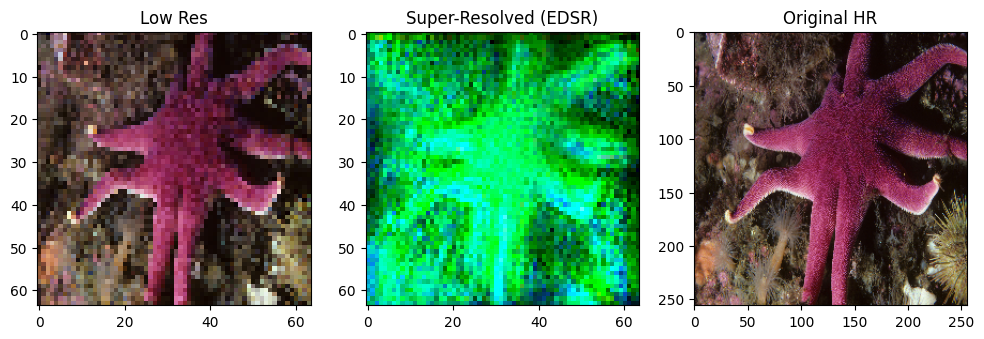

In [ ]:
lr_input = np.expand_dims(lr, axis=0)
sr = edsr_model.predict(lr_input)[0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(lr); plt.title("Low Res")
plt.subplot(1,3,2); plt.imshow(sr); plt.title("Super-Resolved (EDSR)")
plt.subplot(1,3,3); plt.imshow(hr); plt.title("Original HR")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


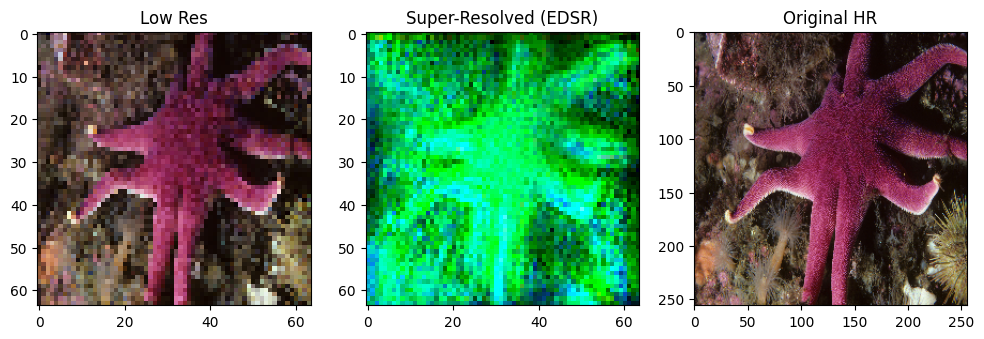

In [ ]:
lr_input = np.expand_dims(lr, axis=0)
sr = edsr_model.predict(lr_input)[0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(lr); plt.title("Low Res")
plt.subplot(1,3,2); plt.imshow(sr); plt.title("Super-Resolved (EDSR)")
plt.subplot(1,3,3); plt.imshow(hr); plt.title("Original HR")
plt.show()
